# MODEL TRAINING - PIPELINE

In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path("..") / "02_src"))

In [2]:
# ----------------------------------
# IMPORTS
#-----------------------------------

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

from sklearn.model_selection import train_test_split, GroupShuffleSplit, GroupKFold, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

from sklearn.preprocessing import RobustScaler, PowerTransformer, OneHotEncoder, FunctionTransformer, PolynomialFeatures

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer, SimpleImputer

from sklearn.cluster import KMeans

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
import scipy.stats as stats

In [3]:
# get main, clean prepared df 
from model_pipeline import data_preparation
df = data_preparation()

### Helper Visualization Functions

In [4]:
# ----------------------------------
# HELPER - MEAN TARGET VARIABLE
#-----------------------------------
def target_mean():
    target = df["child_mortality_igme"]
    target_mean = target.mean()
    print(f"Actual Mean Target: {round(target_mean, 2)}")
    return target_mean

In [5]:
# ----------------------------------
# RESIDUAL PLOT
#-----------------------------------
def residual_plot(y_predicts, residuals, model):
    plt.figure(figsize=(10,4))
    sns.residplot(x=y_predicts, y=residuals, lowess=True, line_kws=dict(color="r"))
    plt.title(f"Residual-Plot for {model}")
    plt.xlabel("Predictions")
    plt.ylabel("Residuals (y_train - y_predicted)")
    plt.show()

def residuals_hist(residuals, model):
    plt.figure(figsize=(10,4))
    sns.histplot(residuals)
    plt.title(f"Resiudals Histogram for {model}")
    plt.show()

In [6]:
# -----------------------------------
# SCATTERPLOT PREDICTED VS REAL
#------------------------------------
def actual_vs_predicted(y_true, y_predicts, residuals, model):
    plt.figure(figsize=(10,4))
    ax = sns.scatterplot(x=y_true, y=y_predicts, hue=residuals, size=residuals)
    
    plt.axline((0,0), slope=1) #https://stackoverflow.com/questions/22104256/does-matplotlib-have-a-function-for-drawing-diagonal-lines-in-axis-coordinates
    ax.set_xlim(-15, y_true.max())
    ax.set_ylim(-15, y_true.max())
    
    plt.title(f"Predicted vs Real Target for {model}")
    plt.ylabel("Predicted Target")
    plt.xlabel("Real Target")
    plt.show()

# Q-Q Plot
def prob_plot(residuals):
    plt.figure(figsize=(10, 5))
    stats.probplot(residuals, plot=plt)
    plt.show()

In [7]:
# -----------------------------------
# METRIC SCORES FOR CV
#------------------------------------
def show_scores(grid, model):
    best_score = grid.best_score_ 
    best_idx = grid.best_index_
    cv_res = pd.DataFrame(grid.cv_results_)

    best_estimator = pd.DataFrame(cv_res.loc[cv_res["mean_test_r2"] == best_score]).reset_index()
    
    print(f"\n------{model} CV SCORES--------")  
    print("\nR2:")
    print(f'''\nTrain Folds R2 Scores: {[round(cv_res[f"split{i}_train_r2"][best_idx], 2) for i in range(8)]}
            \nMean Train R2 Score: {round(cv_res["mean_train_r2"][best_idx], 2)}
            \nTest Folds R2 Scores: {[round(cv_res[f"split{i}_test_r2"][best_idx], 2) for i in range(8)]}
            \nMean Test R2 Score (best_score_): {round(cv_res["mean_test_r2"][best_idx], 2)}''')   
    print("\nMAE:")
    #print(f'MAE error in relation to mean target: {-round( (cv_res["mean_test_mae"][best_idx] / target_mean()) * 100, 2 )} %')
    print(f'''\nTrain Folds MAE Scores: {[-round(cv_res[f"split{i}_train_mae"][best_idx], 2) for i in range(8)]}
            \nMean Train MAE Score: {-round(cv_res["mean_train_mae"][best_idx],2)}
            \nTest Folds MAE Scores: {[-round(cv_res[f"split{i}_test_mae"][best_idx], 2) for i in range(8)]}
            \nMean Test MAE Score: {-round(cv_res["mean_test_mae"][best_idx],2)}
            \nStd Test MAE Score: {round(cv_res["std_test_mae"][best_idx], 2)}''') 
    print("\nRMSE:")
    print(f'''\nTrain Folds RMSE Scores: {[-round(cv_res[f"split{i}_train_rmse"][best_idx], 2) for i in range(8)]}
            \nMean Train RMSE Score: {-round(cv_res["mean_train_rmse"][best_idx], 2)}
            \nTest Folds RMSE Scores: {[-round(cv_res[f"split{i}_test_rmse"][best_idx], 2) for i in range(8)]}
            \nMean Test RMSE Score: {-round(cv_res["mean_test_rmse"][best_idx], 2)}
            \nStd Test MAE Score: {round(cv_res["std_test_rmse"][best_idx], 2)}''')
    print("-----------------------------------------\n")

metrics = {"r2": "r2", "mae": "neg_mean_absolute_error", "rmse": "neg_root_mean_squared_error", "rmsle": "neg_root_mean_squared_log_error"}

### Variables & Train-Test Split

In [21]:
# ----------------------------------
# VARIABLES: Features, Target, Group
#-----------------------------------

y = df["child_mortality_igme"] #target
X = df.drop(columns=["Code", "Year", "Entity", "child_mortality_igme"]) #features
group = df["Entity"]

num_variables = X.drop(columns=["world_regions_wb", "world_income_group"]).columns.to_list()
cat_variables = ["world_regions_wb", "world_income_group"]
regions_list = sorted(X["world_regions_wb"].dropna().unique())
incomegroups_list = sorted(X["world_income_group"].dropna().unique())

others = ["years_of_schooling", "share_of_population_urban", "vaccination_coverage_who_unicef"] #leftskewed or normal-skewed vars
skewed_variables = num_variables.copy() #rightskewed vars
for el in others:
    if el in skewed_variables:
        skewed_variables.remove(el)

world_regions = ["world_regions_wb"]
income_groups = ["world_income_group"]

['East Asia and Pacific (WB)',
 'Europe and Central Asia (WB)',
 'Latin America and Caribbean (WB)',
 'Middle East, North Africa, Afghanistan and Pakistan (WB)',
 'North America (WB)',
 'South Asia (WB)',
 'Sub-Saharan Africa (WB)']

In [9]:
# ----------------------------------
# Train/Test Split
#-----------------------------------

gs_split = GroupShuffleSplit(n_splits=1, train_size=0.8, test_size=0.2, random_state=99)
train_index, test_index = next(gs_split.split(X, y, group))

X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]
group_train = group.iloc[train_index]
group_test  = group.iloc[test_index]

In [10]:
# Combis
def comb_feature(X):
    X = X.copy()
    X["bip_water"] = X["nurses_and_midwives_per_1000_people"] * X["physicians_per_1000_people"]
    return X[["bip_water"]]

#comb_features = FunctionTransformer(comb_feature)

### Kmeans Cluster

In [22]:
# -------------------------------------
# KMeans Cluster outside of Pipeline
#--------------------------------------

X_train_cluster = X_train[num_variables].copy()

kmeans_rscaler = RobustScaler()
X_kmeans_scaled = kmeans_rscaler.fit_transform(X_train_cluster)

knn_impute = KNNImputer(n_neighbors=5, weights="distance")
X_kmeans_imputed = knn_impute.fit_transform(X_kmeans_scaled)

km_train = KMeans(n_clusters=6, random_state=99)
km_train.fit(X_kmeans_imputed)

km_dist_train = km_train.transform(X_kmeans_imputed)

km_distcols = [f"kmeans_dist_{i}" for i in range(km_dist_train.shape[1])]
X_cl_train = X_train.copy()
X_cl_train[km_distcols] = km_dist_train
kmeans_cluster_columns = pd.DataFrame(km_dist_train, columns=km_distcols, index=X_cl_train.copy().index)
#X_cl_train = pd.concat([X_train.copy(), kmeans_cluster_columns], axis=1) #create new X from X_train & append kmeans cols

#### Visualize Cluster with PCA

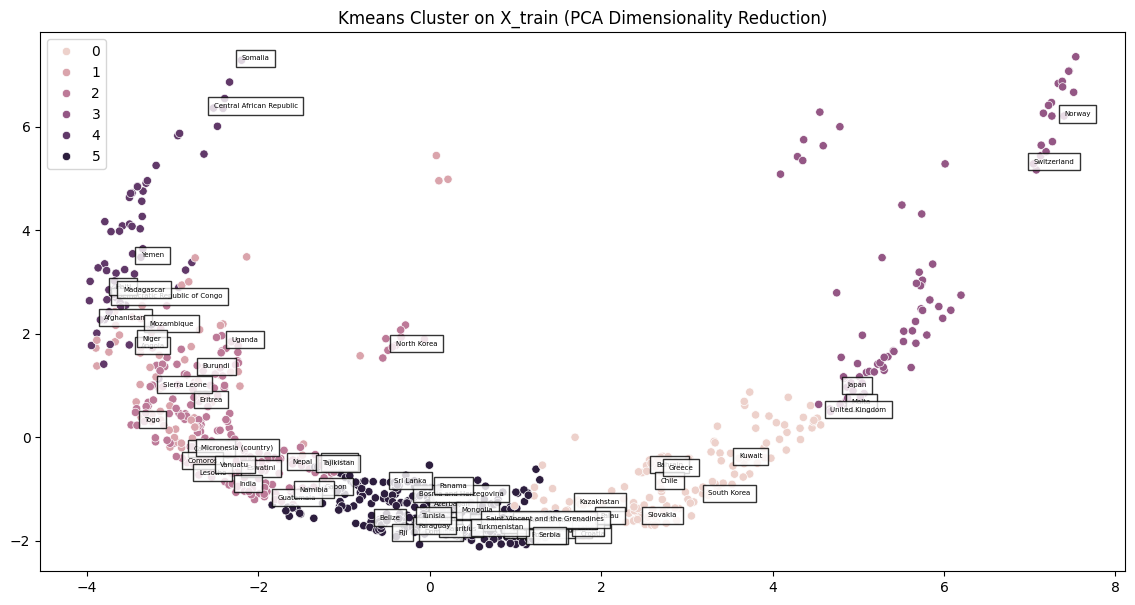

In [23]:
from sklearn.decomposition import PCA

df_imputed = pd.DataFrame(
    X_kmeans_imputed,
    columns=X_cl_train[num_variables].columns,  
    index=X_cl_train[num_variables].index      
)

X_cluster_pca = pd.concat([df_imputed.copy(), kmeans_cluster_columns], axis=1)
X_cluster_pca["Entity"] = df["Entity"]
X_cluster_dist = X_cluster_pca[["kmeans_dist_0", "kmeans_dist_1", "kmeans_dist_2", "kmeans_dist_3", "kmeans_dist_4", "kmeans_dist_5"]]

clusters = X_cluster_dist.values.argmin(axis=1)

X_2d = PCA(n_components=2).fit_transform(X_cluster_dist)
plt.figure(figsize=(14, 7))
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=clusters)

n=14
for i, c in enumerate(X_cluster_pca["Entity"]):
    if i % n == 0:
        plt.text(X_2d[i, 0], X_2d[i, 1], c, fontsize=5, bbox=dict(facecolor="white", alpha=0.8))
plt.title("Kmeans Cluster on X_train (PCA Dimensionality Reduction)")
plt.show()

### Preprocessing Pipeline

In [19]:
# ------------------------------------------
# Preprocessing, Training & CROSS VALIDATION
#------------------------------------------

# handle numeric variables
num_pipeline = Pipeline([
    ("imputer", KNNImputer(n_neighbors=5, weights="distance", add_indicator=False)),
    ("transformer", PowerTransformer()),
    ("scaler", RobustScaler()),

    #("imputer", KNNImputer(n_neighbors=5, weights="distance", add_indicator=False)),
    #("log", FunctionTransformer(np.log1p)),
    #("scaler", RobustScaler())
])

right_skew_transformer = Pipeline(steps=[
    ("imputer", KNNImputer(n_neighbors=5, weights="distance", add_indicator=False)),
    ("log", FunctionTransformer(np.log1p)),
    ("scale", RobustScaler()) 
])

rest_transformer = Pipeline(steps=[
    ("imputer", KNNImputer(n_neighbors=5, weights="distance", add_indicator=False)),
    ("log", PowerTransformer()),
    ("scale", RobustScaler()) 
])

# handle categoric variable
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(
        #drop = "first",
        handle_unknown = "ignore",
        categories=[regions_list, incomegroups_list],
        sparse_output=False
    ))
])
               
preprocessor = ColumnTransformer(transformers=[
    ("numeric_1", right_skew_transformer, skewed_variables),
    ("numeric_2", rest_transformer, others),
    ("categoric", cat_pipeline, cat_variables),
    #('combined', Pipeline([
    #    ('interact', comb_features),
    #    ("imputer", KNNImputer(n_neighbors=5, weights="distance", add_indicator=False)),
    #    ('log', FunctionTransformer(np.log1p)),
    #    ('scale', RobustScaler()) 
    # ]), ['nurses_and_midwives_per_1000_people', 'physicians_per_1000_people'])
    
    #("comb_features", comb_features, ["nurses_and_midwives_per_1000_people", "physicians_per_1000_people"]),
    
    #("drop_cols", "drop", year_col)
    
], remainder="passthrough")

gk = GroupKFold(n_splits=8)

### Baseline Model (Linear Regression)

In [20]:
from sklearn.model_selection import cross_validate
# -------------------------------------------------
# BASELINE MODEL: LINEAR REGRESSION  NON-REGULARIZED
#--------------------------------------------------
lr_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])
#Target is rightskewed, logtransform y before training
lr_pipeline_y_log = TransformedTargetRegressor(
    regressor=lr_pipeline,
    func=np.log1p,
    inverse_func=np.expm1
)

lr_r2_cv = cross_val_score(lr_pipeline_y_log, X_cl_train, y_train, groups=group_train, cv=gk, scoring="r2")
lr_mae_cv = cross_val_score(lr_pipeline_y_log, X_cl_train, y_train, groups=group_train, cv=gk, scoring="neg_mean_absolute_error")
lr_rmse_cv = cross_val_score(lr_pipeline_y_log, X_cl_train, y_train, groups=group_train, cv=gk, scoring="neg_root_mean_squared_error")
lr_r2_score = lr_r2_cv
lr_mae_score = -lr_mae_cv
lr_rmse_score = -lr_rmse_cv
# print crossvalidations scores (splitted into gk-folds (5), fit on gk - 1 & evaluate on last fold > iterate 5times)
print("\n------LINEAR REGRESSION CV SCORES--------")
print("\nR2:")
print(f"\nFolds R2 scores: {lr_r2_score}\nMean R2 Score: {round(lr_r2_score.mean(), 2)}")
print("\nMAE:")
#print(f"MAE error in relation to mean target: {round( (lr_mae_score.mean() / target_mean()) * 100, 2 )} %")
print(f"\nFolds MAE scores: {lr_mae_score}\nMean MAE Score: {round(lr_mae_score.mean(), 2)}\nStd MAE Score: {round(lr_mae_score.std(), 2)}")
print("\nRMSE:")
print(f"\nFolds RMSE scores: {lr_rmse_score}\nMean RMSE Score: {round(lr_rmse_score.mean(), 2)}\nStd RMSE Score: {round(lr_rmse_score.std(), 2)}\n")
print("-----------------------------------------\n")


lr_cv_results = cross_validate(
    estimator=lr_pipeline_y_log,
    X=X_cl_train,
    y=y_train,
    groups=group_train,          
    cv=gk,
    scoring=metrics,
    return_train_score=True 
)
print(f'Train r2 mean: {lr_cv_results["train_r2"].mean()}, Train mae mean: {-lr_cv_results["train_mae"].mean()}, Train rmse mean: {-lr_cv_results["train_rmse"].mean()}')


------LINEAR REGRESSION CV SCORES--------

R2:

Folds R2 scores: [0.78405908 0.85223678 0.75303058 0.61351455 0.80889023 0.69677527
 0.81030748 0.80835863]
Mean R2 Score: 0.77

MAE:

Folds MAE scores: [10.67557869  6.78305196 11.21301336 15.63094237  9.46374129  7.35140684
  9.44214087  8.81188779]
Mean MAE Score: 9.92
Std MAE Score: 2.57

RMSE:

Folds RMSE scores: [14.50674576  9.25417153 16.23005311 35.06105882 15.93508596 11.2180173
 15.18966659 14.85618817]
Mean RMSE Score: 16.53
Std RMSE Score: 7.36

-----------------------------------------

Train r2 mean: 0.8094775281848781, Train mae mean: 8.324691124102152, Train rmse mean: 15.55680708225356


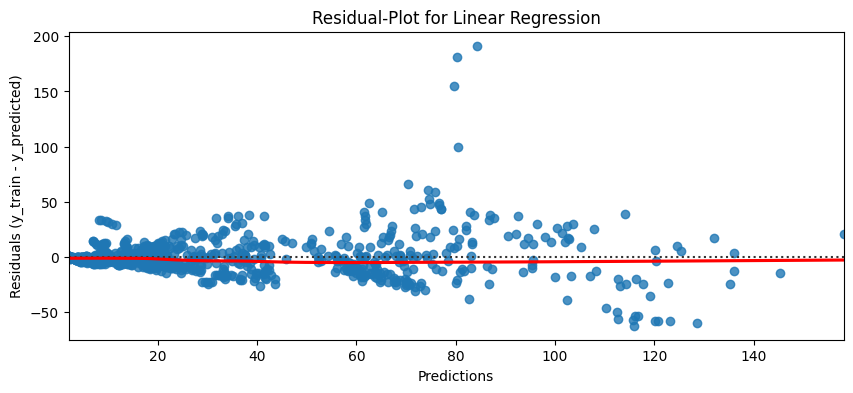

In [198]:
# -------------------------------------------------
# RESIDUAL PLOT FOR BASE MODEL: LINEAR REGRESSION NON-REGULARIZED
#--------------------------------------------------
lr_y_predicts = cross_val_predict(lr_pipeline_y_log, X_cl_train, y_train, groups=group_train, cv=gk)
lr_residuals = y_train - lr_y_predicts

residual_plot(lr_y_predicts, lr_residuals, "Linear Regression")

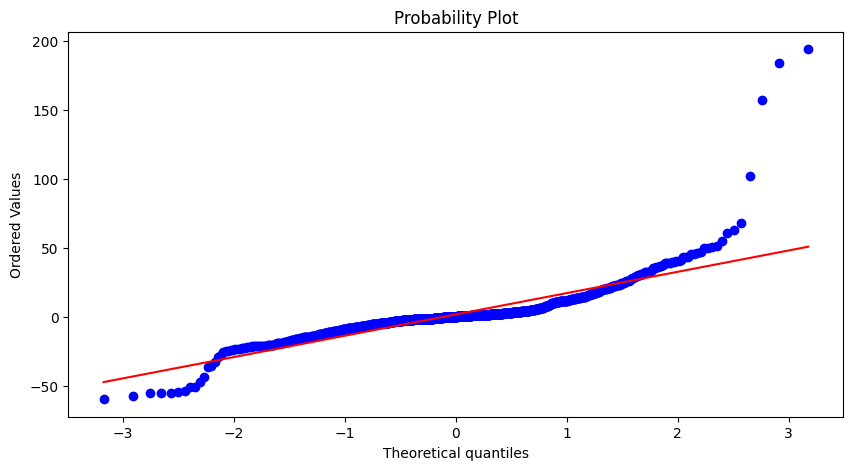

In [199]:
# -------------------------------------------------
# Quantile-Quantile-Plot OF RESIDUALS FOR BASE MODEL
#--------------------------------------------------
prob_plot(lr_residuals)

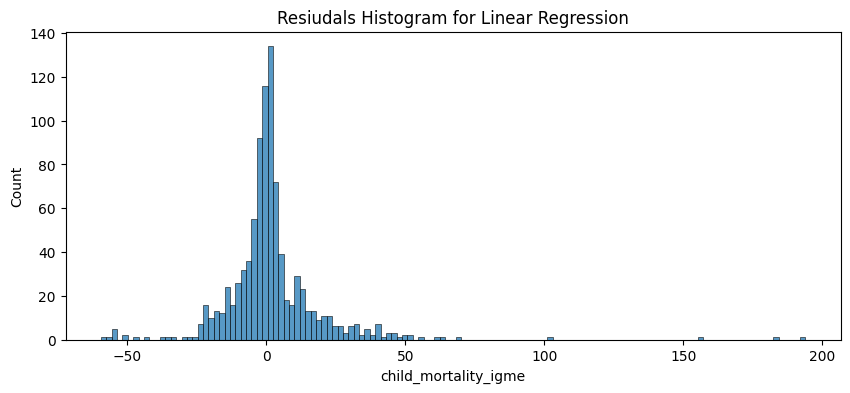

In [200]:
# -------------------------------------------------
# HISTOGRAM PLOT OF RESIDUALS FOR BASE MODEL: LINEAR REGRESSION NON-REGULARIZED
#--------------------------------------------------
residuals_hist(lr_residuals, "Linear Regression")

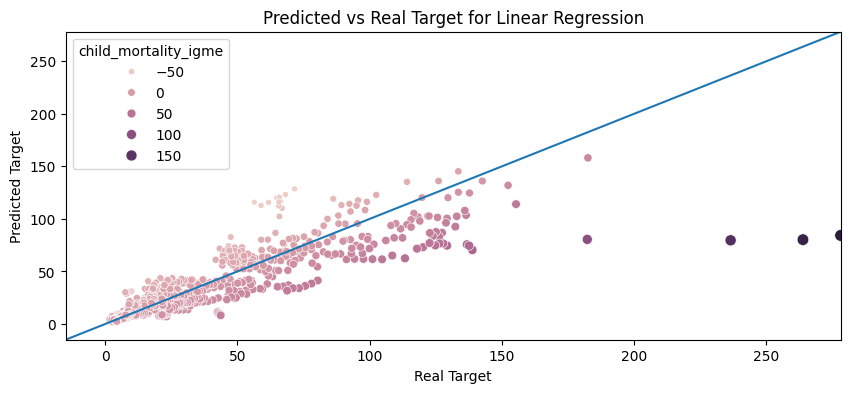

In [201]:
# -------------------------------------------------
# SCATTER PREDICED VS REAL FOR BASE MODEL: LINEAR REGRESSION NON-REGULARIZED
#--------------------------------------------------
actual_vs_predicted(y_train, lr_y_predicts, lr_residuals, "Linear Regression")

### Ridge

In [202]:
# -------------------------------------------------
# REGULARIZED LINEAR MODEL (RIDGE)
#--------------------------------------------------
ridge_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", Ridge())
])
#Target is rightskewed, logtransform y before training
ridge_pipeline_y_log  = TransformedTargetRegressor(
    regressor=ridge_pipeline,
    func=np.log1p,
    inverse_func=np.expm1
)

ridge_param_grid = {
    "regressor__model__alpha": [0.01, 0.1, 1, 10, 100]
}
# fit trainset via GridSearchCV
ridge_grid = GridSearchCV(ridge_pipeline_y_log, ridge_param_grid, cv=gk, scoring=metrics, refit="mae", return_train_score=True, n_jobs=-1)
ridge_grid.fit(X_cl_train, y_train, groups=group_train)
best_ridge_model = ridge_grid.best_estimator_
# print metrics scores
show_scores(ridge_grid, "Ridge")
ridge_grid.best_estimator_


------Ridge CV SCORES--------

R2:

Train Folds R2 Scores: [0.8, 0.8, 0.81, 0.85, 0.8, 0.81, 0.8, 0.79]
            
Mean Train R2 Score: 0.81
            
Test Folds R2 Scores: [0.79, 0.87, 0.79, 0.62, 0.82, 0.71, 0.82, 0.8]
            
Mean Test R2 Score (best_score_): 0.78

MAE:

Train Folds MAE Scores: [8.42, 8.86, 8.01, 7.75, 8.52, 8.61, 8.72, 8.92]
            
Mean Train MAE Score: 8.48
            
Test Folds MAE Scores: [10.35, 6.48, 10.43, 15.79, 9.26, 7.3, 9.27, 9.04]
            
Mean Test MAE Score: 9.74
            
Std Test MAE Score: 2.62

RMSE:

Train Folds RMSE Scores: [16.35, 16.63, 15.61, 12.1, 15.79, 16.36, 16.18, 16.64]
            
Mean Train RMSE Score: 15.71
            
Test Folds RMSE Scores: [14.36, 8.75, 15.02, 34.89, 15.52, 11.04, 14.73, 15.34]
            
Mean Test RMSE Score: 16.21
            
Std Test MAE Score: 7.41
-----------------------------------------



,regressor,Pipeline(step...e(alpha=10))])
,transformer,None
,func,<ufunc 'log1p'>
,inverse_func,<ufunc 'expm1'>
,check_inverse,True
,transformers,"[('numeric_1', ...), ('numeric_2', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


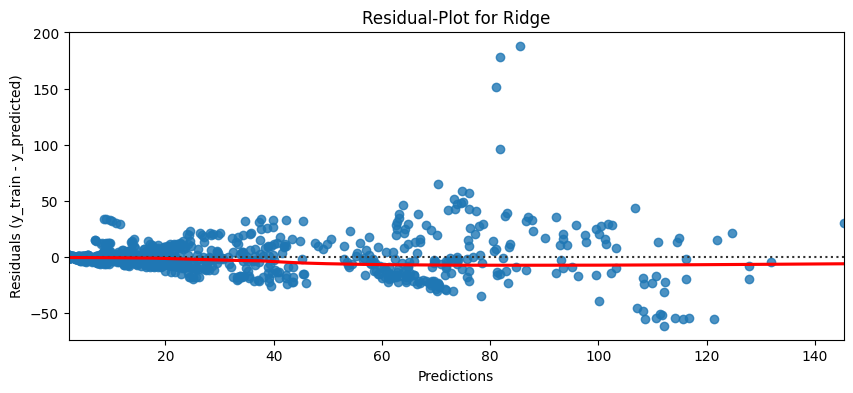

In [203]:
# -------------------------------------------------
# RESIDUAL PLOT FOR RIDGE
#--------------------------------------------------
ridge_y_predicts = cross_val_predict(best_ridge_model, X_cl_train, y_train, groups=group_train, cv=gk)
ridge_residuals = y_train - ridge_y_predicts

residual_plot(ridge_y_predicts, ridge_residuals, "Ridge")

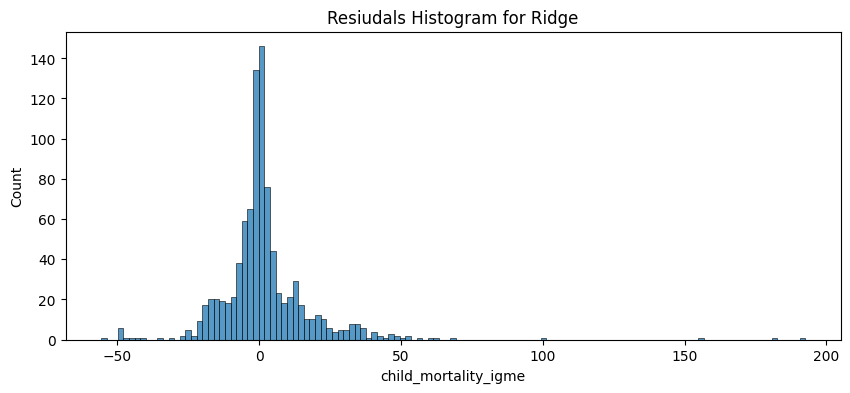

In [204]:
# -------------------------------------------------
# HISTOGRAM PLOT OF RESIDUALS FOR RIDGE MODEL
#--------------------------------------------------
residuals_hist(ridge_residuals, "Ridge")

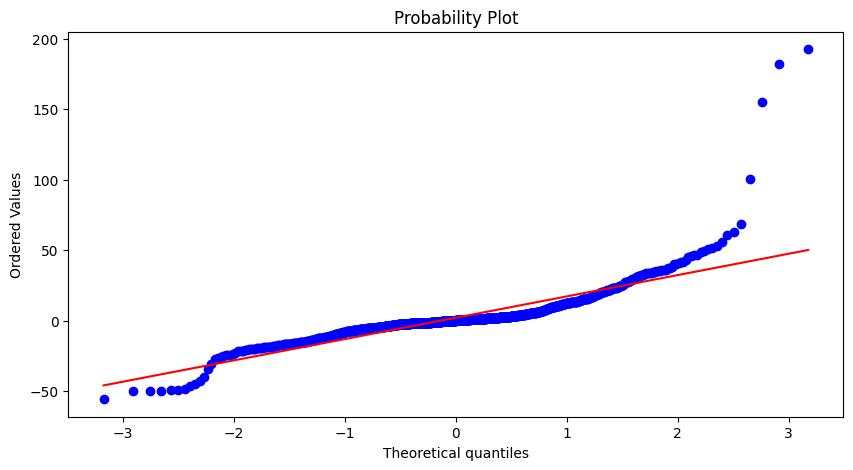

In [205]:
# -------------------------------------------------
# Quantile-Quantile-Plot OF RESIDUALS FOR RIDGE 
#--------------------------------------------------
prob_plot(ridge_residuals)

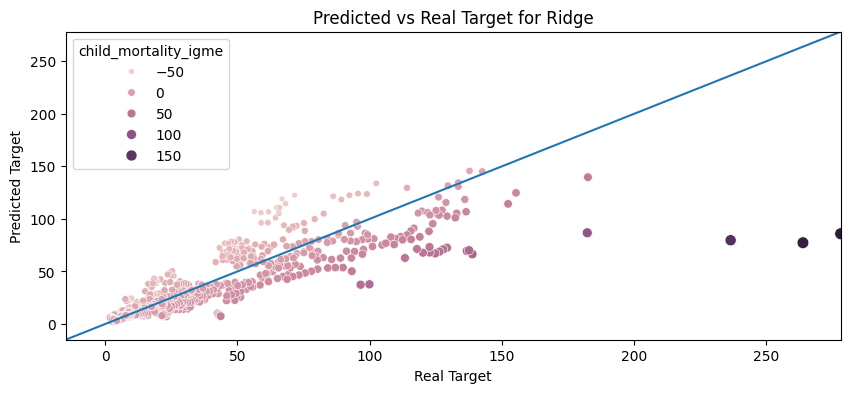

In [154]:
# -------------------------------------------------
# SCATTER PREDICED VS REAL FOR RIDGE
#--------------------------------------------------
actual_vs_predicted(y_train, ridge_y_predicts, ridge_residuals, "Ridge")

### ElasticNet

In [215]:
# -------------------------------------------------
# REGULARIZED LINEAR MODEL ELASTICNET
#--------------------------------------------------
elasticnet_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", ElasticNet(max_iter=5000,random_state=99))
])
#Target is rightskewed, logtransform y before training
elasticnet_pipeline_y_log = TransformedTargetRegressor(
    regressor=elasticnet_pipeline,
    func=np.log1p,
    inverse_func=np.expm1
)

elasticnet_param_grid = {
    "regressor__model__alpha": [0.01, 0.1, 1],
    "regressor__model__l1_ratio": [0.1, 0.2, 0.5, 0.8]
}

elasticnet_grid = GridSearchCV(elasticnet_pipeline_y_log, elasticnet_param_grid, cv=gk, scoring=metrics, refit="mae", return_train_score=True, n_jobs=-1)
elasticnet_grid.fit(X_cl_train, y_train, groups=group_train)
best_elasticnet_model = elasticnet_grid.best_estimator_

show_scores(elasticnet_grid, "ElasticNet")

elasticnet_grid.best_estimator_
#pd.DataFrame(elasticnet_grid.cv_results_)


------ElasticNet CV SCORES--------

R2:

Train Folds R2 Scores: [0.79, 0.8, 0.8, 0.84, 0.8, 0.8, 0.8, 0.78]
            
Mean Train R2 Score: 0.8
            
Test Folds R2 Scores: [0.79, 0.88, 0.8, 0.64, 0.82, 0.71, 0.8, 0.81]
            
Mean Test R2 Score (best_score_): 0.78

MAE:

Train Folds MAE Scores: [8.66, 8.95, 8.41, 7.92, 8.68, 8.81, 8.79, 9.06]
            
Mean Train MAE Score: 8.66
            
Test Folds MAE Scores: [10.31, 6.31, 10.45, 15.41, 9.13, 7.1, 9.37, 8.92]
            
Mean Test MAE Score: 9.62
            
Std Test MAE Score: 2.57

RMSE:

Train Folds RMSE Scores: [16.54, 16.63, 16.04, 12.49, 16.03, 16.45, 16.07, 16.71]
            
Mean Train RMSE Score: 15.87
            
Test Folds RMSE Scores: [14.36, 8.38, 14.7, 34.03, 15.33, 10.88, 15.55, 14.87]
            
Mean Test RMSE Score: 16.01
            
Std Test MAE Score: 7.21
-----------------------------------------



,regressor,Pipeline(step...m_state=99))])
,transformer,None
,func,<ufunc 'log1p'>
,inverse_func,<ufunc 'expm1'>
,check_inverse,True
,transformers,"[('numeric_1', ...), ('numeric_2', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


In [216]:
best_elasticnet_model.regressor_.named_steps["model"].n_iter_

143

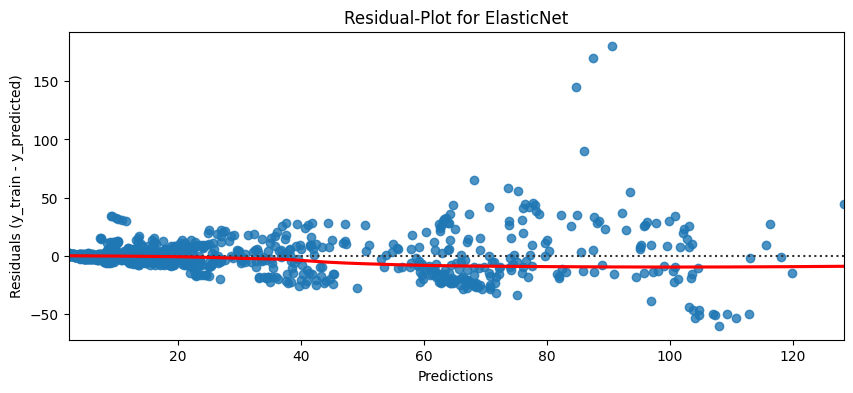

In [217]:
# -------------------------------------------------
# RESIDUAL PLOT FOR ELASTICNET
#--------------------------------------------------
elasticnet_y_predicts = cross_val_predict(best_elasticnet_model, X_cl_train, y_train, groups=group_train, cv=gk)
elasticnet_residuals = y_train - elasticnet_y_predicts

residual_plot(elasticnet_y_predicts, elasticnet_residuals, "ElasticNet")

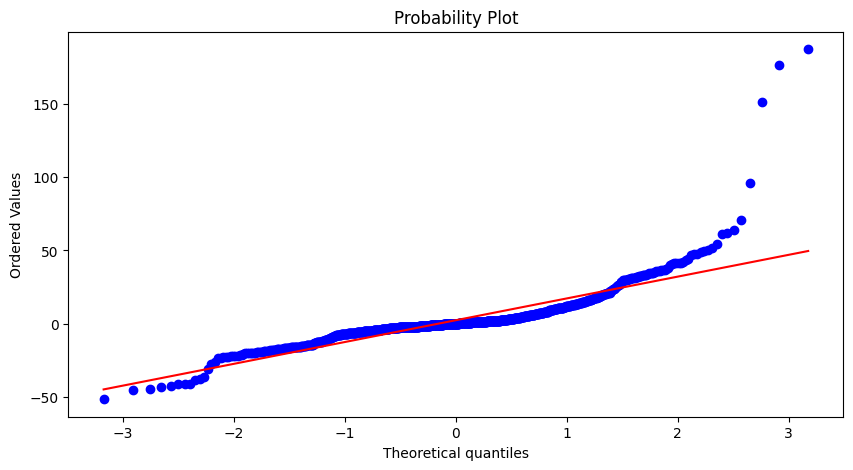

In [218]:
# -------------------------------------------------
# Quantile-Quantile-Plot OF RESIDUALS FOR ELASTICNET 
#--------------------------------------------------
prob_plot(elasticnet_residuals)

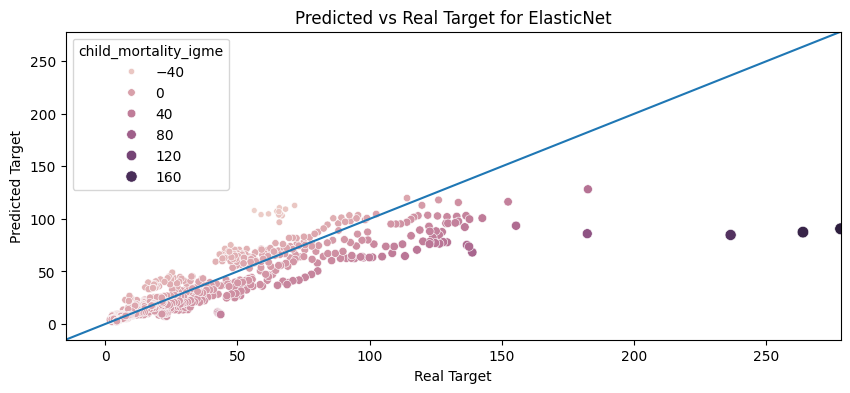

In [219]:
# -------------------------------------------------
# SCATTER PREDICED VS REAL FOR ELASTUCNET
#--------------------------------------------------
actual_vs_predicted(y_train, elasticnet_y_predicts, elasticnet_residuals, "ElasticNet")

#### Holdout Testset

In [370]:
#final_elastic_model = best_elasticnet_model.fit(X_cl_train, y_train)

X_holdout_testset = X_test[num_variables].copy()

X_test_elastic = X_holdout_testset.copy()
X_test_elastic_scaled = kmeans_rscaler.transform(X_test_elastic)  
X_test_elastic_imputed = knn_impute.transform(X_test_elastic_scaled)  

km_dist_el_test = km_train.transform(X_test_elastic_imputed)
kmeans_cluster_columns_el_test = pd.DataFrame(km_dist_el_test,
                                           columns=km_distcols,
                                           index=X_test_elastic.index)


X_test_final_elastic = pd.concat([X_test.copy(), kmeans_cluster_columns_el_test], axis=1)
elasticnet_y_pred_holdout = best_elasticnet_model.predict(X_test_final_elastic)
MAE_test = mean_absolute_error(y_test, elasticnet_y_pred_holdout)
R2_test  = r2_score(y_test, elasticnet_y_pred_holdout)

print(f"----ElasticNet best model on holdout Testset: Final Metric Scores----\n MAE: {MAE_test}, R2: {R2_test}")

----ElasticNet best model on holdout Testset: Final Metric Scores----
 MAE: 5.763090078892802, R2: 0.8472860387439112


#### Permuation Importance

In [238]:
from sklearn.inspection import permutation_importance
pi_result_el = permutation_importance(best_elasticnet_model, X_test_final_elastic, y_test, n_repeats=10, random_state=42)
importance_df_elasticnet = pd.DataFrame({
    'feature': X_test_final_elastic.columns,
    'importance_mean': np.round(pi_result_el.importances_mean, 4),
    'importance_std': np.round(pi_result_el.importances_std, 4)
}).sort_values(by='importance_mean', ascending=False)

importance_df_elasticnet

,feature,importance_mean,importance_std
12,kmeans_dist_1,0.2504,0.0450
14,kmeans_dist_3,0.2032,0.0338
9,world_regions_wb,0.1979,0.0267
15,kmeans_dist_4,0.0684,0.0133
6,share_without_improved_water,0.0655,0.0083
11,kmeans_dist_0,0.0647,0.0164
1,gdp_per_capita_worldbank,0.0513,0.0087
8,years_of_schooling,0.0253,0.0052
0,annual_healthcare_expenditure_per_capita,0.0074,0.0026
4,prevalence_of_undernourishment,0.0054,0.0032


### Random Forest Regressor

In [170]:
# -------------------------------------------------
# RF
#--------------------------------------------------
rf_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(random_state=99))
])
#Target is rightskewed, logtransform y before training
rf_pipeline_y_log = TransformedTargetRegressor(
    regressor=rf_pipeline,
    func=np.log1p,
    inverse_func=np.expm1
)

rf_param_grid = {
    "regressor__model__n_estimators": [300, 500],
    "regressor__model__max_depth": [1, 3],
    "regressor__model__min_samples_split": [5, 15],
    "regressor__model__min_samples_leaf": [20, 30],
    "regressor__model__max_features": [0.2],
    "regressor__model__max_samples": [0.7, 0.8]
}

rf_grid = GridSearchCV(rf_pipeline_y_log, rf_param_grid, cv=gk, scoring=metrics, refit="mae", return_train_score=True, n_jobs=-1)
rf_grid.fit(X_cl_train, y_train, groups=group_train)
best_rf_model = rf_grid.best_estimator_

show_scores(rf_grid, "RF")
rf_grid.best_estimator_


------RF CV SCORES--------

R2:

Train Folds R2 Scores: [0.75, 0.74, 0.74, 0.77, 0.73, 0.74, 0.74, 0.74]
            
Mean Train R2 Score: 0.74
            
Test Folds R2 Scores: [0.59, 0.88, 0.74, 0.5, 0.75, 0.68, 0.77, 0.67]
            
Mean Test R2 Score (best_score_): 0.7

MAE:

Train Folds MAE Scores: [9.24, 9.96, 9.18, 8.69, 9.55, 9.83, 9.46, 9.38]
            
Mean Train MAE Score: 9.41
            
Test Folds MAE Scores: [12.78, 5.98, 11.4, 19.61, 9.36, 8.28, 10.0, 11.9]
            
Mean Test MAE Score: 11.16
            
Std Test MAE Score: 3.78

RMSE:

Train Folds RMSE Scores: [18.22, 18.84, 18.32, 15.15, 18.38, 19.04, 18.3, 18.32]
            
Mean Train RMSE Score: 18.07
            
Test Folds RMSE Scores: [20.04, 8.41, 16.6, 39.9, 18.33, 11.58, 16.78, 19.62]
            
Mean Test RMSE Score: 18.91
            
Std Test MAE Score: 8.78
-----------------------------------------



,regressor,Pipeline(step...m_state=99))])
,transformer,None
,func,<ufunc 'log1p'>
,inverse_func,<ufunc 'expm1'>
,check_inverse,True
,transformers,"[('numeric_1', ...), ('numeric_2', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


#### RF Residual Plot & Actual vs Predicted 

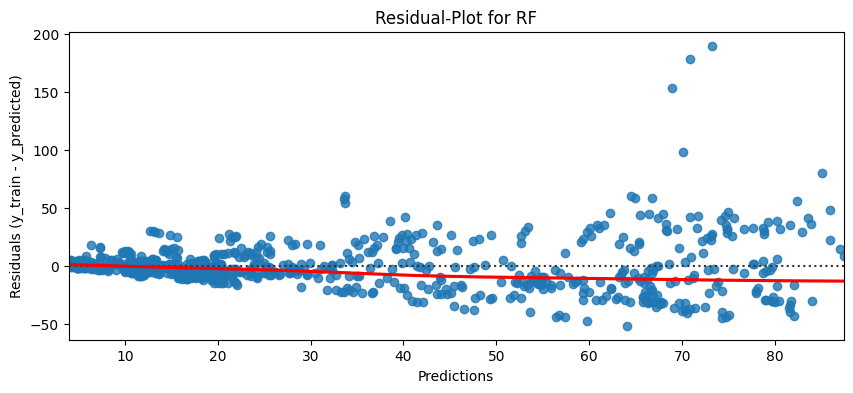

In [239]:
rf_y_predicts = cross_val_predict(best_rf_model, X_cl_train, y_train, groups=group_train, cv=gk)
rf_residuals = y_train - rf_y_predicts

residual_plot(rf_y_predicts, rf_residuals, "RF")

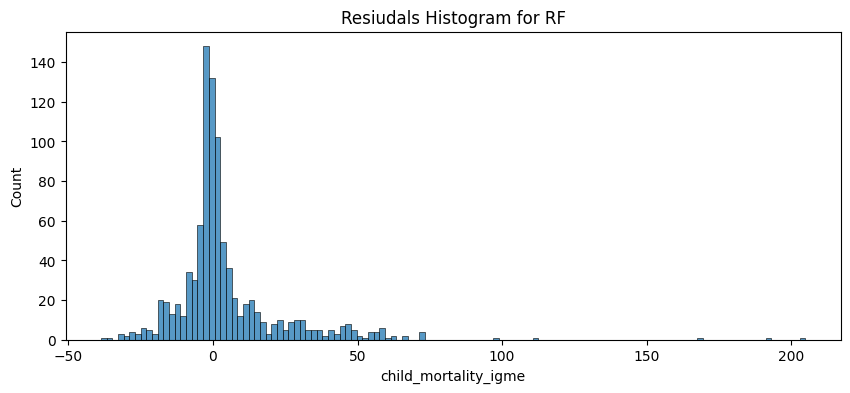

In [240]:
residuals_hist(rf_residuals, "RF")

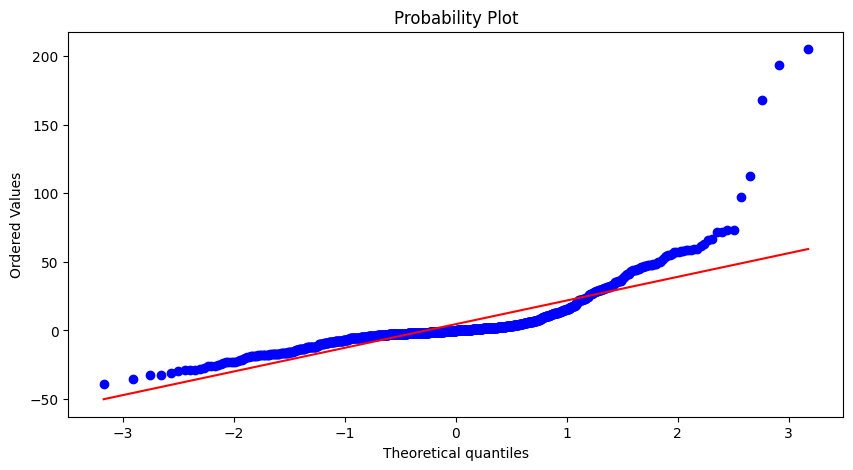

In [241]:
# -------------------------------------------------
# Quantile-Quantile-Plot OF RESIDUALS FOR RF 
#--------------------------------------------------
prob_plot(rf_residuals)

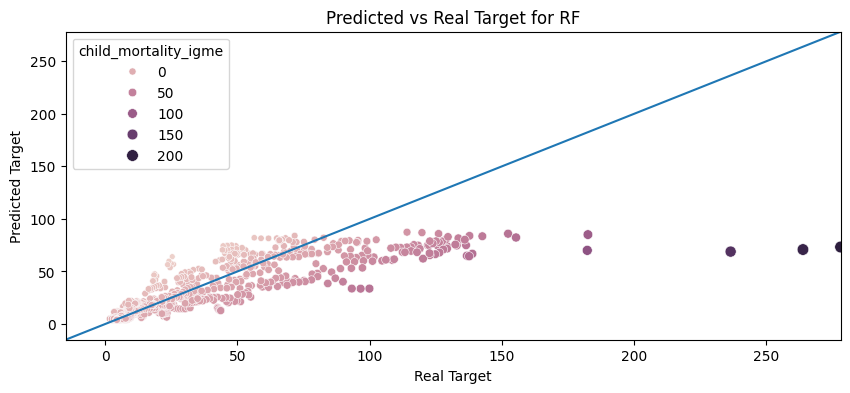

In [242]:
actual_vs_predicted(y_train, rf_y_predicts, rf_residuals, "RF")

### XGBoost Regressor 

In [363]:
# -------------------------------------------------
# XGBOOST
#--------------------------------------------------
xgb_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", XGBRegressor(objective="reg:squarederror", n_jobs=-1, random_state=42))
])
#Target is rightskewed, logtransform y before training
xgb_pipeline_y_log = TransformedTargetRegressor(
    regressor=xgb_pipeline,
    func=np.log1p,
    inverse_func=np.expm1
)

#xgb_param_grid = {
#    'regressor__model__n_estimators': [100, 300, 600],
#    'regressor__model__max_depth': [4, 6],
#    'regressor__model__learning_rate': [0.01, 0.05],
#    'regressor__model__subsample': [0.6, 0.8],
#    'regressor__model__colsample_bytree': [0.5, 0.8], 
#    'regressor__model__min_child_weight': [1, 5]
#}

from scipy.stats import randint, uniform, loguniform

xgb_param_grid = {
    "regressor__model__n_estimators": [200, 500],
    "regressor__model__max_depth": [2, 4],
    "regressor__model__learning_rate": [0.05, 0.1],
    "regressor__model__subsample": [0.6, 0.8],          
    #"regressor__model__colsample_bytree": [0.5, 0.7],
    #"regressor__model__gamma": [1.0],  
    "regressor__model__min_child_weight": [10, 12],
    "regressor__model__reg_alpha": [0.1, 0.5],
    "regressor__model__reg_lambda": [1, 3],
}
#w = np.sqrt(np.log1p(y_train))
#w = np.clip(w, 0.5, 5.0)
#w = w / w.mean()
#xgb_search = RandomizedSearchCV(estimator=xgb_pipeline_y_log, param_distributions=xgb_param_grid, n_iter=40, cv=gk, scoring=metrics, refit="rmsle", n_jobs=-1, return_train_score=True, verbose=2, random_state=99, error_score="raise")
xgb_search = GridSearchCV(xgb_pipeline_y_log, xgb_param_grid, cv=gk, scoring=metrics, refit="mae", n_jobs=-1, return_train_score=True)

xgb_search.fit(X_cl_train, y_train, groups=group_train)

show_scores(xgb_search, "XGB")

best_xgb_model = xgb_search.best_estimator_
best_xgb_model


------XGB CV SCORES--------

R2:

Train Folds R2 Scores: [0.89, 0.88, 0.9, 0.93, 0.88, 0.9, 0.89, 0.89]
            
Mean Train R2 Score: 0.89
            
Test Folds R2 Scores: [0.67, 0.83, 0.8, 0.63, 0.85, 0.65, 0.88, 0.79]
            
Mean Test R2 Score (best_score_): 0.76

MAE:

Train Folds MAE Scores: [5.9, 6.09, 5.67, 5.37, 6.13, 5.85, 6.06, 6.07]
            
Mean Train MAE Score: 5.89
            
Test Folds MAE Scores: [12.11, 6.93, 10.28, 14.73, 8.69, 7.53, 8.05, 9.56]
            
Mean Test MAE Score: 9.73
            
Std Test MAE Score: 2.44

RMSE:

Train Folds RMSE Scores: [12.14, 12.55, 11.61, 8.49, 12.14, 11.97, 11.9, 12.13]
            
Mean Train RMSE Score: 11.62
            
Test Folds RMSE Scores: [17.93, 9.97, 14.58, 34.33, 14.15, 12.13, 12.0, 15.53]
            
Mean Test RMSE Score: 16.33
            
Std Test MAE Score: 7.18
-----------------------------------------



,regressor,"Pipeline(step...te=42, ...))])"
,transformer,None
,func,<ufunc 'log1p'>
,inverse_func,<ufunc 'expm1'>
,check_inverse,True
,transformers,"[('numeric_1', ...), ('numeric_2', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


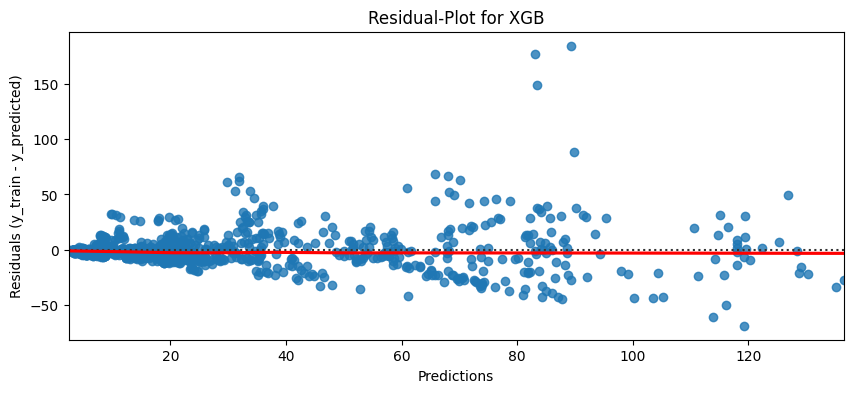

In [364]:
xgb_y_predicts = cross_val_predict(best_xgb_model, X_train, y_train, groups=group_train, cv=gk)
xgb_residuals = y_train - xgb_y_predicts

residual_plot(xgb_y_predicts, xgb_residuals, "XGB")

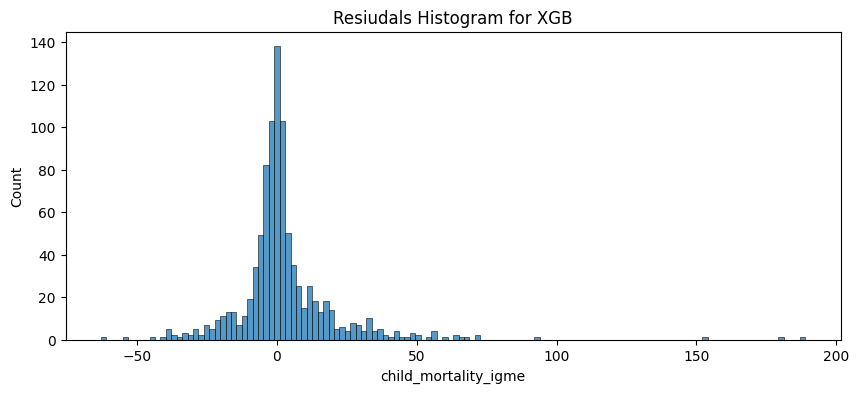

In [365]:
residuals_hist(xgb_residuals, "XGB")

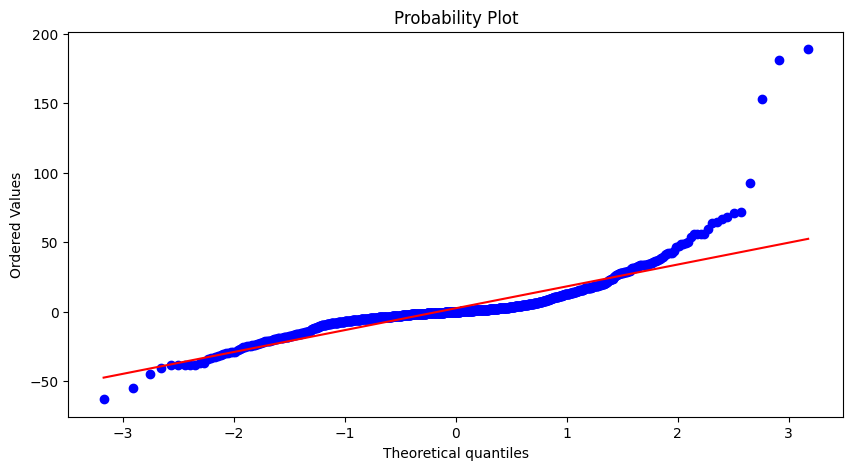

In [366]:
# -------------------------------------------------
# Quantile-Quantile-Plot OF RESIDUALS FOR XGB
#--------------------------------------------------
prob_plot(xgb_residuals)

In [367]:
#actual_vs_predicted(y_train, xgb_y_predicts, xgb_residuals, "XGB")

#### XGB Holdout Test

In [373]:
#final_elastic_model = best_elasticnet_model.fit(X_cl_train, y_train)

#X_holdout_testset = X_test[num_variables].copy()

X_test_xgb = X_holdout_testset.copy()
X_test_xgb_scaled = kmeans_rscaler.transform(X_test_xgb)  
X_test_xgb_imputed = knn_impute.transform(X_test_xgb_scaled)  

km_dist_xgb_test = km_train.transform(X_test_xgb_imputed)
kmeans_cluster_columns_xgb_test = pd.DataFrame(km_dist_xgb_test,
                                           columns=km_distcols,
                                           index=X_test_xgb.index)


X_test_final_xgb = pd.concat([X_test.copy(), kmeans_cluster_columns_xgb_test], axis=1)
xgb_y_pred_holdout = best_xgb_model.predict(X_test_final_xgb)
MAE_test = mean_absolute_error(y_test, xgb_y_pred_holdout)
R2_test  = r2_score(y_test, xgb_y_pred_holdout)

print(f"----XGB best model on holdout Testset: Final Metric Scores----\n MAE: {MAE_test}, R2: {R2_test}")

----XGB best model on holdout Testset: Final Metric Scores----
 MAE: 5.518917580223854, R2: 0.8483575931443629
